In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

sns.set_theme(style="whitegrid")

# Load the dataset
df = pd.read_csv("../online_retail_II.csv", encoding="unicode_escape", dtype={"Customer ID": str})

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   object 
 7   Country      1067371 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 65.1+ MB


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [11]:
df_clean = df.copy()

# Convert 'InvoiceDate' to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')

# remove lines without 'Customer ID'
df_clean = df_clean.dropna(subset=['Customer ID'])

# remove transactions with negative or zero quantity
df_clean = df_clean[df_clean['Quantity'] > 0]

#transform 'Customer ID' to int
df_clean['Customer ID'] = df_clean['Customer ID'].astype(float).astype(int)

df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 805620 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805620 non-null  object        
 1   StockCode    805620 non-null  object        
 2   Description  805620 non-null  object        
 3   Quantity     805620 non-null  int64         
 4   InvoiceDate  805620 non-null  datetime64[ns]
 5   Price        805620 non-null  float64       
 6   Customer ID  805620 non-null  int64         
 7   Country      805620 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 55.3+ MB


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


recency

In [9]:
# recency of the last purchase
snapshot_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)

# recency
recency_df = df_clean.groupby('Customer ID').agg(Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days)).reset_index()

recency_df.head()


,Customer ID,Recency
0,12346,326
1,12347,2
2,12348,75
3,12349,19
4,12350,310


frequency and monetary

In [14]:
# Create a new column for the total price
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']

# frequency and monetary
frequency_monetary_df = df_clean.groupby('Customer ID').agg(Frequency=('Invoice', 'nunique'), Monetary=('TotalPrice', 'sum')).reset_index()

frequency_monetary_df.head(10)

# Merge recency, frequency, and monetary dataframes
RFM_df = recency_df.merge(frequency_monetary_df, on='Customer ID')
RFM_df.head(10)


,Customer ID,Recency,Frequency,Monetary
0,12346,326,12,77556.46
1,12347,2,8,5633.32
2,12348,75,5,2019.40
3,12349,19,4,4428.69
4,12350,310,1,334.40
5,12351,375,1,300.93
6,12352,36,10,2849.84
7,12353,204,2,406.76
8,12354,232,1,1079.40
9,12355,214,2,947.61


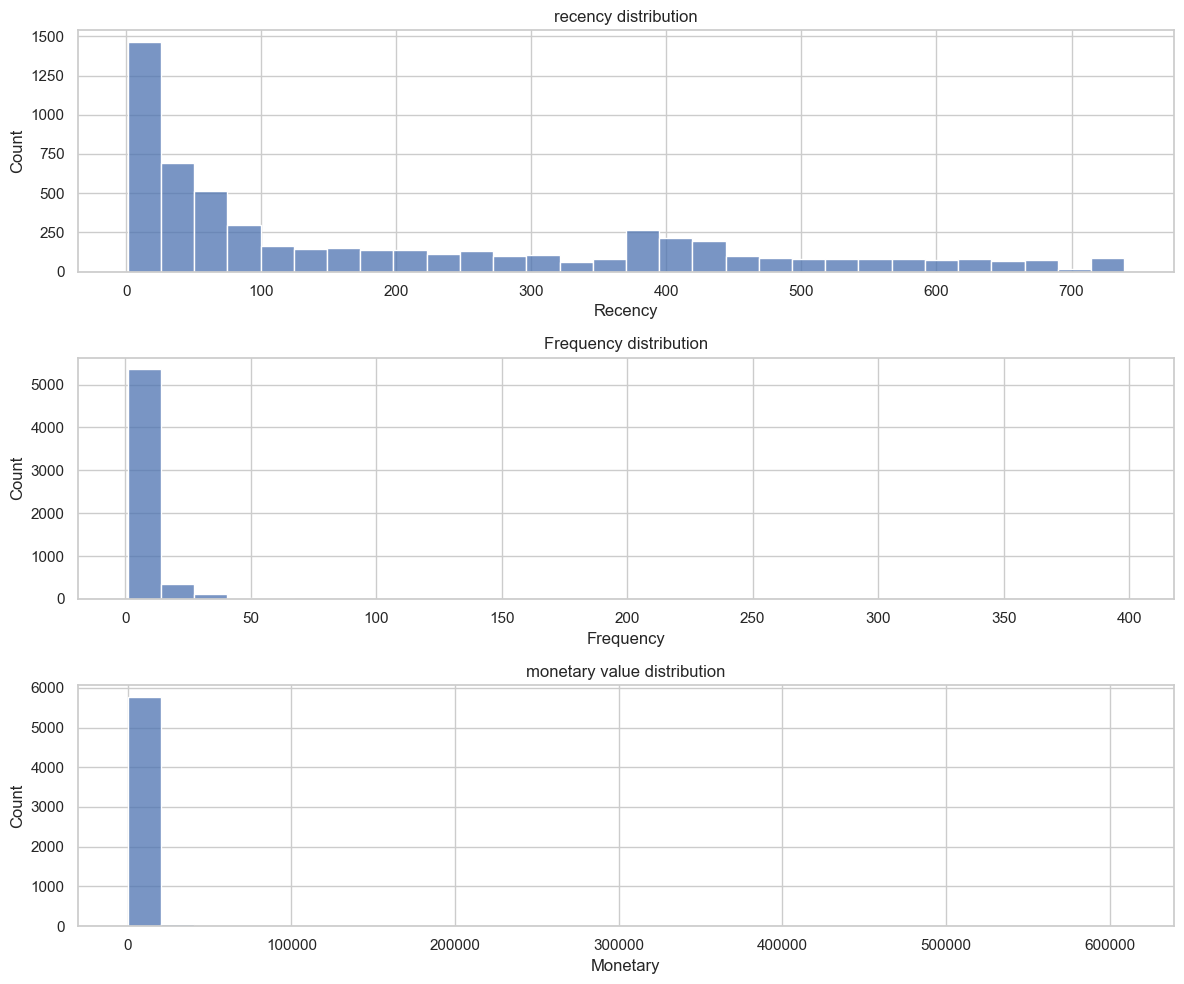

In [16]:
plt.figure(figsize=(12, 10))

# Plotting the distribution of Recency
plt.subplot(3, 1, 1)
sns.histplot(RFM_df['Recency'], bins=30)
plt.title('recency distribution')

# Plotting the distribution of Frequency
plt.subplot(3, 1, 2)
sns.histplot(RFM_df['Frequency'], bins=30)
plt.title('Frequency distribution')

# Plotting the distribution of Monetary
plt.subplot(3, 1, 3)
sns.histplot(RFM_df['Monetary'], bins=30)
plt.title('monetary value distribution')

plt.tight_layout() # to prevent overlap
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler

# standardizing the RFM values
scaler = StandardScaler()

RFM_scaled = scaler.fit_transform(RFM_df[['Recency', 'Frequency', 'Monetary']])
RFM_scaled_df = pd.DataFrame(RFM_scaled, columns=['Recency', 'Frequency', 'Monetary'])
RFM_scaled_df.head()

,Recency,Frequency,Monetary
0,0.594598,0.439049,5.059391
1,-0.952264,0.131635,0.177579
2,-0.603743,-0.098925,-0.067718
3,-0.871102,-0.175779,0.095814
4,0.518209,-0.406339,-0.182088


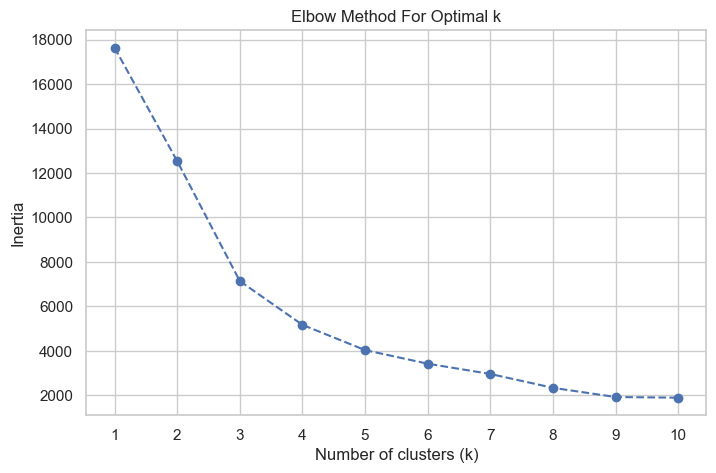

In [19]:
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the Elbow Method
inertia= []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(RFM_scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.show()


In [27]:
#training the KMeans model with the optimal number of clusters (e.g., k=4)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
RFM_df['Cluster'] = kmeans.fit_predict(RFM_scaled_df)

RFM_df.head()
RFM_df['Cluster'].value_counts().sort_index()


Cluster
0    3840
1    2002
2      35
3       4
Name: count, dtype: int64

In [36]:
cluster_analysis = RFM_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)

cluster_analysis

,Recency,Frequency,Monetary
Cluster,,,
0,66.89,7.31,3009.12
1,463.03,2.21,765.75
2,25.94,103.74,83086.08
3,3.50,212.75,436835.79


In [ ]:
cluster_map = {
    3: 'high-value customers(B2B)',
    2: 'medium-value customers',
    0: 'low-value customers',
    1: 'at-risk customers'
}

# adding a new column 'Persona' to our main RFM dataframe
RFM_df['Persona'] = RFM_df['Cluster'].map(cluster_map)


# ordering the analysis table by Monetary value
cluster_analysis_sorted = cluster_analysis.sort_values(by='Monetary', ascending=False)

# Add the Persona column to this analysis table as well, for clarity
cluster_analysis_sorted['Persona'] = cluster_analysis_sorted.index.map(cluster_map)



# Showing the final analysis of customer segments (sorted by Monetary value)
print(cluster_analysis_sorted[['Persona', 'Recency', 'Frequency', 'Monetary']])
# showing the first 10 rows of the RFM dataframe with the new 'Persona' column

print(RFM_df.head(10))

                           Persona  Recency  Frequency   Monetary
Cluster                                                          
3        high-value customers(B2B)     3.50     212.75  436835.79
2           medium-value customers    25.94     103.74   83086.08
0              low-value customers    66.89       7.31    3009.12
1                at-risk customers   463.03       2.21     765.75
   Customer ID  Recency  Frequency  Monetary  Cluster              Persona
0        12346      326         12  77556.46        0  low-value customers
1        12347        2          8   5633.32        0  low-value customers
2        12348       75          5   2019.40        0  low-value customers
3        12349       19          4   4428.69        0  low-value customers
4        12350      310          1    334.40        1    at-risk customers
5        12351      375          1    300.93        1    at-risk customers
6        12352       36         10   2849.84        0  low-value customers
7   